<a href="https://colab.research.google.com/github/Arifulhaque-02128/ML_Projects/blob/main/medical_specialist_classification_using_tfidf_and_smote_and_gloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [12]:
df = pd.read_excel("/content/gdrive/MyDrive/NLP/Project/Bengali_medical_specialist_classificattion/Bengali Colloquial Dataset for Primary Medical Issues/Specialist Classification.xlsx")


In [4]:
df.head()

,Patient ID,Problem,Specialist
0,NaN,NaN,NaN
1,1.0,আমার তিন দিন যাবত অনেক মাথা ব্যথা,Medicine
2,2.0,আমার প্রায় এক সপ্তাহ ধরে রোদে গেলেই মাথা ধরে য...,Medicine
3,3.0,আমার বোনের কয়েকদিন ধরে চোখ আর মাথা ব্যথা,Medicine
4,4.0,আমার মায়ের কপালের দুই দিকে অনেক ব্যথা করে আর ন...,Medicine


In [5]:
df.isnull().sum()

Patient ID    1
Problem       1
Specialist    1
dtype: int64

In [6]:
new_df = df.dropna()

In [7]:
new_df.isnull().sum()

Patient ID    0
Problem       0
Specialist    0
dtype: int64

In [8]:
new_df.head()

,Patient ID,Problem,Specialist
1,1.0,আমার তিন দিন যাবত অনেক মাথা ব্যথা,Medicine
2,2.0,আমার প্রায় এক সপ্তাহ ধরে রোদে গেলেই মাথা ধরে য...,Medicine
3,3.0,আমার বোনের কয়েকদিন ধরে চোখ আর মাথা ব্যথা,Medicine
4,4.0,আমার মায়ের কপালের দুই দিকে অনেক ব্যথা করে আর ন...,Medicine
5,5.0,আমার অনেক মাথা ব্যথা করে,Medicine


In [9]:
new_df["Specialist"].value_counts()

Specialist
Medicine           278
Ophthalmologist     72
Gynecologist        64
Surgery             63
Orthopedic          50
Skin                48
Dentist             45
Cardiologist        44
ENT                 40
Name: count, dtype: int64

In [13]:
sns.set(style="ticks", context="talk", font_scale=1.5)
plt.style.use("dark_background")

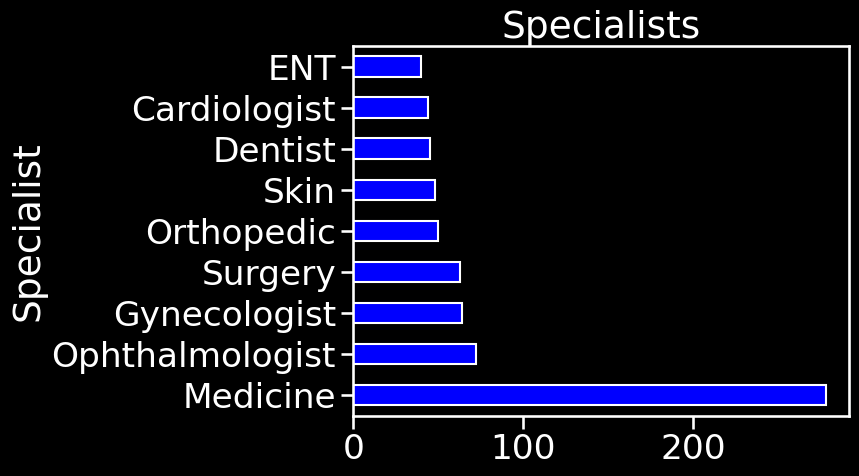

In [14]:
new_df["Specialist"].value_counts().plot.barh(color='blue', title='Specialists',);

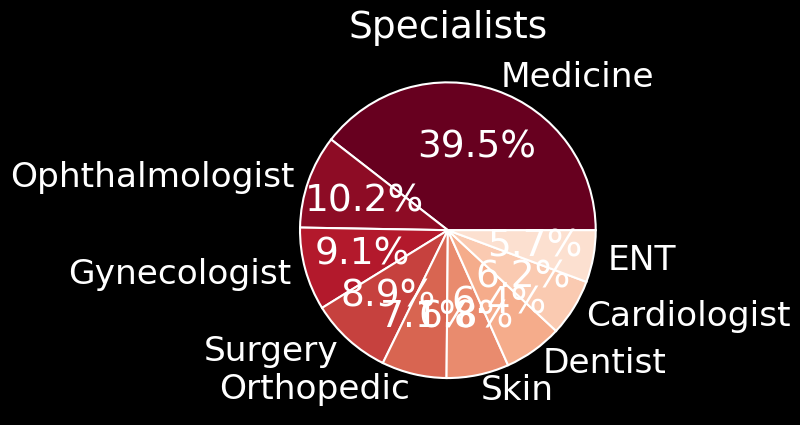

In [15]:
color = plt.cm.RdBu(np.linspace(0,1,20))
new_df["Specialist"].value_counts().sort_values(ascending=False).head(10).plot.pie(y="Gender",colors=color,autopct="%0.1f%%")
plt.title("Specialists")
plt.axis("off")
plt.show()

In [16]:
den = new_df[(new_df['Specialist']=='Dentist')].reset_index(drop=True)
den.head()

,Patient ID,Problem,Specialist
0,20.0,আমার দাঁত শিরশির করে। ঠান্ডা বা গরম কিছু খেতে ...,Dentist
1,21.0,আমার দাঁত ভেঙ্গে যাচ্ছে,Dentist
2,22.0,আমার মাড়ি অনেক ব্যথা আর ব্রাশ করার সময় রক্ত পর...,Dentist
3,23.0,আমার দাঁতে কালো দাগ হচ্ছে কোনোভাবেই দাগ যাচ্ছে...,Dentist
4,24.0,আমি দাঁতে জোর পাচ্ছি না।,Dentist


In [17]:
surg = new_df[(new_df['Specialist']=='Surgery')].reset_index(drop=True)
surg.head()

,Patient ID,Problem,Specialist
0,11.0,আমার মুখে অনেক বড় ফোঁড়ার মত উঠে আর লাল হয়ে থাক...,Surgery
1,96.0,আমার স্তনে প্রচন্ড ব্যথা করে। প্রায় এক মাস ধরে...,Surgery
2,97.0,আমার নিপল অনেক চুল্কায় এবং সাদা ময়লার মত বের হয়।,Surgery
3,98.0,নিপল অনেক ব্যথা করে আর ফুলে গিয়েছে আর চাপ দিলে...,Surgery
4,99.0,আমার নিপলে লাল গোটার মত বের হয়েছে এবং লাল হয়ে ...,Surgery


In [18]:
ski = new_df[(new_df['Specialist']=='Skin')].reset_index(drop=True)
ski.head()

,Patient ID,Problem,Specialist
0,9.0,আমার কপালে গোটার মত বের হয়েছে,Skin
1,10.0,আমার অনেক ব্রণ হয় মুখে। আর অনেক ব্যথা করে।,Skin
2,12.0,আমার মুখে গোটা উঠে মুখে কালো দাগ পরে যাচ্ছে।,Skin
3,13.0,আমার নাকে আর থুতনিতে সাদা বিচির মত উঠে আর মুখ ...,Skin
4,55.0,আমি ধুলায় গেলে আমার স্কিন অনেক চুল্কায় আর ফুলে...,Skin


In [19]:
import re,nltk,json

In [20]:
data1 = pd.read_excel('/content/gdrive/MyDrive/NLP/Project/stopwords_bangla.xlsx')
stopwords = data1['words'].tolist()

### Cleaning Data

In [21]:
# # Cleaning Data [Remove unncessary symbols]
# def cleaning_data(problem):
#       problems = re.sub('[^\u0980-\u09FF]',' ',str(problem)) #removing unnecessary punctuation
#       return problems
# # Apply the function into the dataframe
# new_df['cleaned_problem'] = new_df['Problem'].apply(cleaning_data)



def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out



In [22]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords]

    out=' '.join(stm)

    return str(out)

In [23]:
new_df['cleaned_problem'] = new_df['Problem'].apply(preprocessing)
new_df['cleaned_problem'] = new_df['cleaned_problem'].apply(stopwordRemoval)

# print some cleaned reviews from the dataset
sample_data = [20,50,100,200,300,350,400,450,500,600]
for i in sample_data:
  print('Original: ', new_df.Problem[i],'\nCleaned:',
           new_df.cleaned_problem[i],'\n','Category:-- ', new_df.Specialist[i],'\n')

Original:  আমার দাঁত শিরশির করে। ঠান্ডা বা গরম কিছু খেতে পারি না। অনেক অস্বস্তি লাগে। 
Cleaned: দাঁত শিরশির ঠান্ডা গরম খেতে অস্বস্তি 
 Category:--  Dentist 

Original:  আমি কাছ থেকে কিছু দেখতে গেলে অনেক মাথা ব্যথা করে মনে হয় চোখে অনেক প্রেসার পরছে। 
Cleaned: মাথা চোখে প্রেসার পরছে 
 Category:--  Ophthalmologist 

Original:  আমার স্তনের নিপল দিয়ে দুধের মত সাদা রস বের হতে থাকে কিন্তু আমি প্রেগন্যান্ট না। 
Cleaned: স্তনের নিপল দুধের সাদা রস প্রেগন্যান্ট 
 Category:--  Surgery 

Original:  আমার পায়ে পানি আসছে। ঠিকমত হাঁটতে পারছি না 
Cleaned: পায়ে পানি আসছে ঠিকমত হাঁটতে পারছি 
 Category:--  Medicine 

Original:  আমি কাছ থেকে কিছু দেখতে গেলে অনেক মাথা ব্যথা করে মনে হয় চোখে অনেক প্রেসার পরছে। 
Cleaned: মাথা চোখে প্রেসার পরছে 
 Category:--  Ophthalmologist 

Original:  আমার ছেলের রাতের বেলা জ্বর আসে। 
Cleaned: ছেলের রাতের বেলা জ্বর 
 Category:--  Medicine 

Original:  আমার পায়ের আঙ্গুল ফুলে আছে আর প্রচুর ব্যথা করছে। 
Cleaned: পায়ের আঙ্গুল ফুলে প্রচুর 
 Category:--  Medicine 

Original:  আমার 

### Dataset Analysis

In [24]:
def data_summary(dataset):

    """
    This function will print the summary of the problems and words distribution in the dataset.

    Args:
        dataset: list of cleaned sentences

    Returns:
        Number of documnets per class: int
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(new_df.cleaned_problem) for word in t.strip().split()]
    class_label= [k for k,v in new_df.Specialist.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(new_df[new_df.Specialist==label].cleaned_problem) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(new_df[new_df.Specialist==label].cleaned_problem)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(new_df[new_df.Specialist==label].cleaned_problem))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(new_df)


Class Name :  Medicine
Number of Documents:278
Number of Words:1296
Number of Unique Words:390
Most Frequent Words:

মাথা	39
ঠিকমত	36
ঘুম	33
বমি	28
জ্বর	23
শরীর	20
ফুলে	17
পেট	16
পানি	14
পায়খানা	13

Class Name :  Ophthalmologist
Number of Documents:72
Number of Words:320
Number of Unique Words:109
Most Frequent Words:

চোখ	36
চোখে	16
পানি	11
ঠিকমত	11
দেখি	9
চোখের	9
ঝাপ্সা	8
চুল্কায়	7
অস্বস্তি	7
মেয়ে	6

Class Name :  Gynecologist
Number of Documents:64
Number of Words:347
Number of Unique Words:133
Most Frequent Words:

পিরিয়ড	24
পিরিয়ডের	16
সময়	14
সাদা	13
পেট	12
রক্ত	9
আম্মুর	9
স্তনে	8
শক্ত	8
প্রচন্ড	7

Class Name :  Surgery
Number of Documents:63
Number of Words:296
Number of Unique Words:89
Most Frequent Words:

ফুলে	17
বড়	12
আস্তে	12
নিপল	11
স্তন	11
পুঁজ	10
স্তনে	10
মুখে	8
সাদা	8
বোনের	8

Class Name :  Orthopedic
Number of Documents:50
Number of Words:232
Number of Unique Words:91
Most Frequent Words:

হাত	11
মাজা	10
পায়ের	9
হাঁটুতে	8
পায়ে	8
প্রচন্ড	8
নাড়াতে	7
পা	6
ভাড়ি	6
সময়	5

Cl

### Problem Visualization

<ipython-input-25-04e7bfc8576b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, rotation=45);


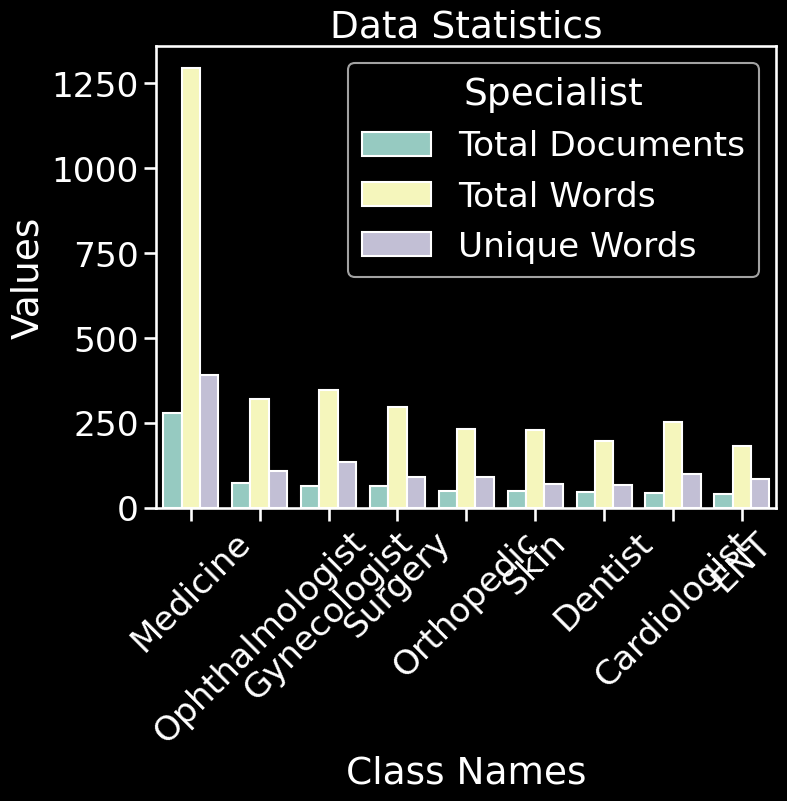

In [25]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Specialist", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Specialist')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

### Problem Text Length Visualization

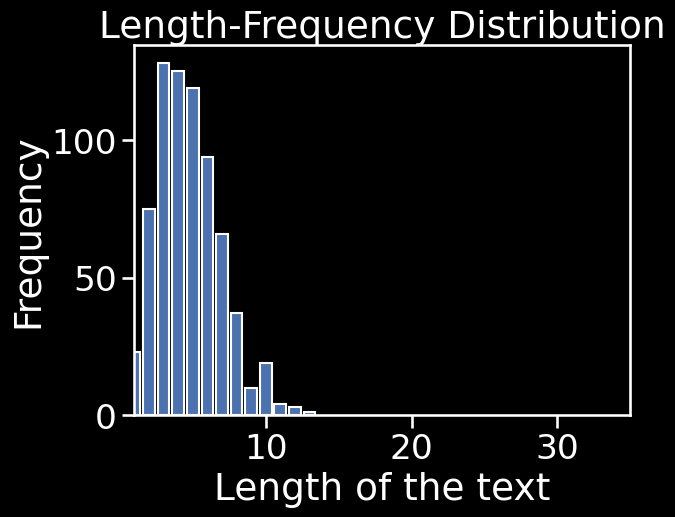

Maximum Length of a text: 13
Minimum Length of a text: 1
Average Length of a text: 5.0


In [26]:
# Calculate the Review of each of the Review
new_df['textLength'] = new_df.cleaned_problem.apply(lambda x:len(x.split()))
frequency = dict()
for i in new_df.textLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 35)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the text')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a text: {max(new_df.textLength)}")
print(f"Minimum Length of a text: {min(new_df.textLength)}")
print(f"Average Length of a text: {round(np.mean(new_df.textLength),0)}")

In [27]:
# segregating dataframe for analyzing individual problem
df_med = new_df[new_df['Specialist'] == 'Medicine']
df_ophtha = new_df[new_df['Specialist'] == 'Ophthalmologist']
df_gyne = new_df[new_df['Specialist'] == 'Gynecologist']
df_surg = new_df[new_df['Specialist'] == 'Surgery']

df_ortho = new_df[new_df['Specialist'] == 'Orthopedic']
df_cardio = new_df[new_df['Specialist'] == 'Cardiologist']
df_skin = new_df[new_df['Specialist'] == 'Skin']
df_dent = new_df[new_df['Specialist'] == 'Dentist']
df_ent = new_df[new_df['Specialist'] == 'ENT']


In [28]:
!pip install wordcloud
!pip install bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171034 sha256=143f4314f423ef2b9cf3b5fc8e349ec356f282385e0205078be8008380087089
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.99
    Uninstalling sentencepiece-0.1.99:
      Successfully uninstalled sentencepiece-0.1.99
  Attempting

In [29]:
!pip install python-bidi
from bidi.algorithm import get_display


Text(0.5, 1.0, 'Word cloud for Medicine')

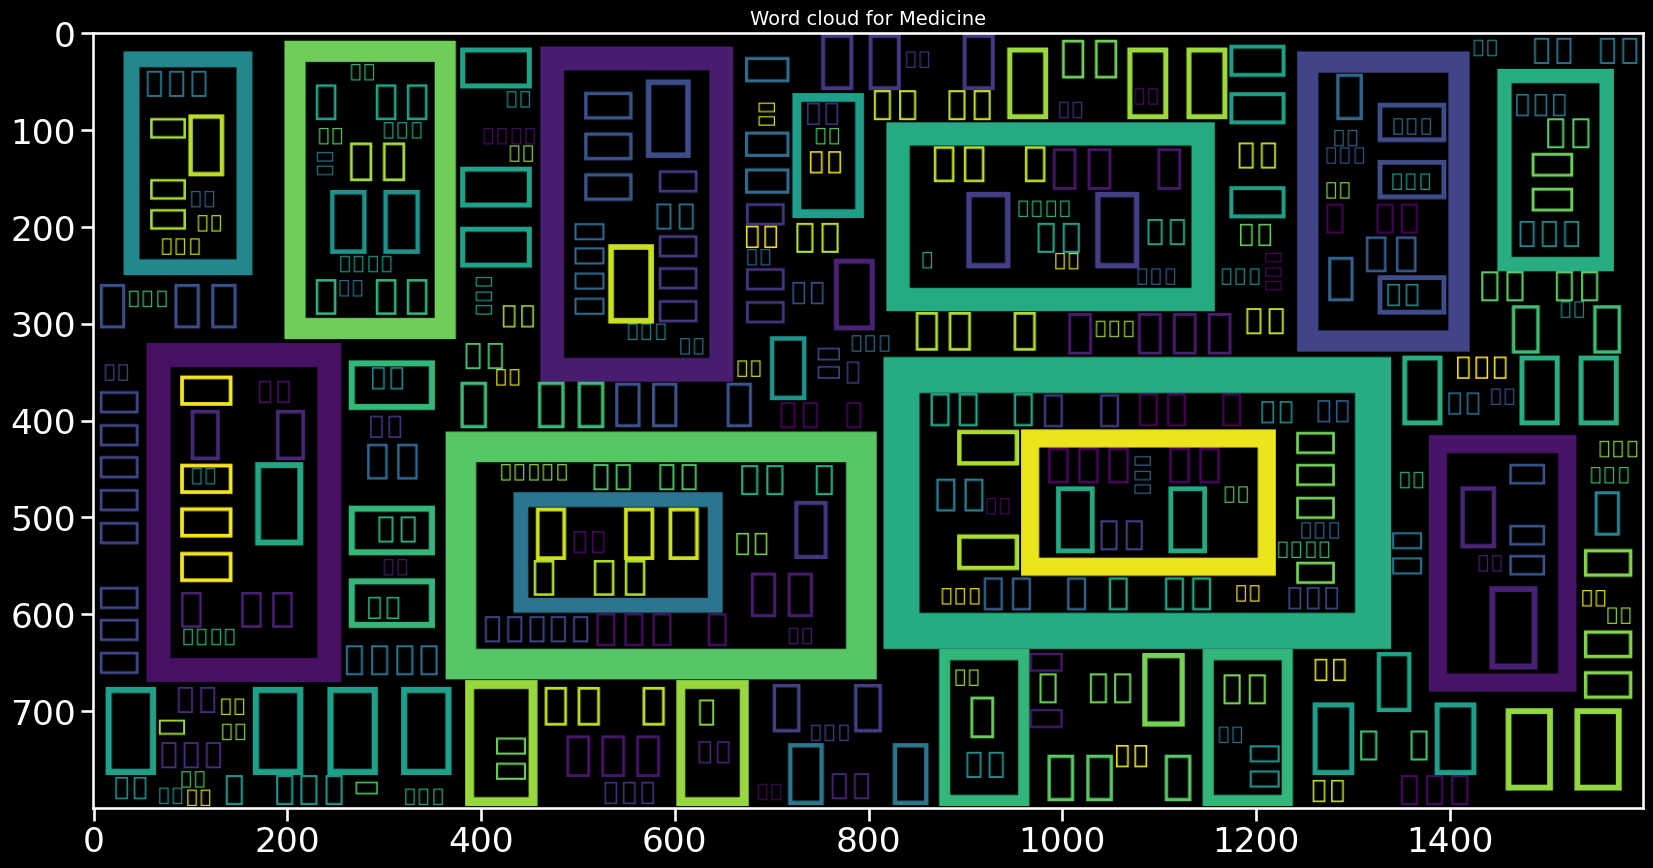

In [30]:
from wordcloud import WordCloud


plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(' '.join(df_med.cleaned_problem))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Medicine', fontsize = 14)

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
def label_encoding(specialist,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        specialist: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(specialist)
    encoded_labels = le.transform(specialist)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->", le.classes_)
        # print("\n\t\t\t===== Labels =====",labels)
        # for i in sample_data:
        #     print(specialist[i],' ', encoded_labels[i],'\n')

    return labels, le

In [39]:
def dataset_split(feature_space,specialist):
    """
    This function will return the splitted (80%-20%) feature vector .

    Args:
        feature_space: calcuated feature vector (sparse matrix)
        specialist: encoded lables (array)

    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,specialist,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])

    return X_train,X_test,y_train,y_test

In [40]:
new_df.cleaned_problem = new_df.cleaned_problem.apply(lambda x:x.replace('\n',' '))

### Model Building Using Machine Learning Feature Extraction Using TF-IDF

In [41]:
# word2Vec using gloVe embedding
word2vec = {}
with open('/content/gdrive/MyDrive/Bangla_News_Article_Dataset/bn_glove.39M.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec


In [43]:
#prepare a tokenizer for problem statement on training

def vectorize_text_glove(texts, embeddings_index, embedding_dim, max_length):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

  return padded_sequences, embedding_matrix

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV

In [45]:
#########  Classifiers Defination  #########
def ml_models_defination():
    """
    This function consists the models defination for All gram Features

    Retuns:
        ml_models: list of models
        model_names: list of model_names

    """


    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

    parameters = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    model = RandomForestClassifier(random_state=42)
    rf_model = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')

    # rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy',class_weight='balanced', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    sgd_model = SGDClassifier(loss='log', random_state=0)

    model_names = ['Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM', 'SGD Classifier']

    # Create list of models
    ml_models = [dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model, sgd_model]
    #ml_models = [lr_model]
    return ml_models, model_names

In [50]:
####### Model Evaluation Function ############

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.

    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)

    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y, average='micro'),4)*100 # try for ---> average='macro'
    my_dict['Recall'] = round(recall_score(y_test, pred_y, average='micro'),4)*100 # try for ---> average='macro'
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y, average='micro'),4)*100 # try for ---> average='macro'

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, pred_y)
    my_dict['Confusion Matrix'] = conf_matrix


    return my_dict

In [51]:
#### Model Performane into Dataframe #####
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.

    Args:
        performance_dict: a dictionary of all the parameters for each models

    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['DT','RF','MNB','KNN','Linear SVM','RBF SVM', 'SGD']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df

In [48]:
def show_confusion_matrix(performance_dict, label_encoder):
    confusion_matrices = {}
    for model_name, metrics in performance_dict.items():
        confusion_matrices[model_name] = metrics['Confusion Matrix']
        # Plotting the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()
    return confusion_matrices


In [ ]:
from imblearn.over_sampling import SMOTE

embedding_dim = 300
max_length = 15  # Define maximum sequence length for padding
X, embedding_matrix = vectorize_text_glove(new_df.cleaned_problem, word2vec, embedding_dim, max_length)

labels, label_encoder = label_encoding(new_df.Specialist, False)

X_train,X_test,y_train,y_test = dataset_split(X,labels)

# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ml_models,model_names = ml_models_defination()
# call model accuracy function and save the metrices into a dictionary
accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
acc = accuracy


Feature Size :======> 15

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 704 
	Training		 563 
	Test			 141


In [ ]:
acc

### Performance Table

In [ ]:
# Load all the json files

table = performance_table(accuracy)
print(f"\n========== Performace :========\n",table)

print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


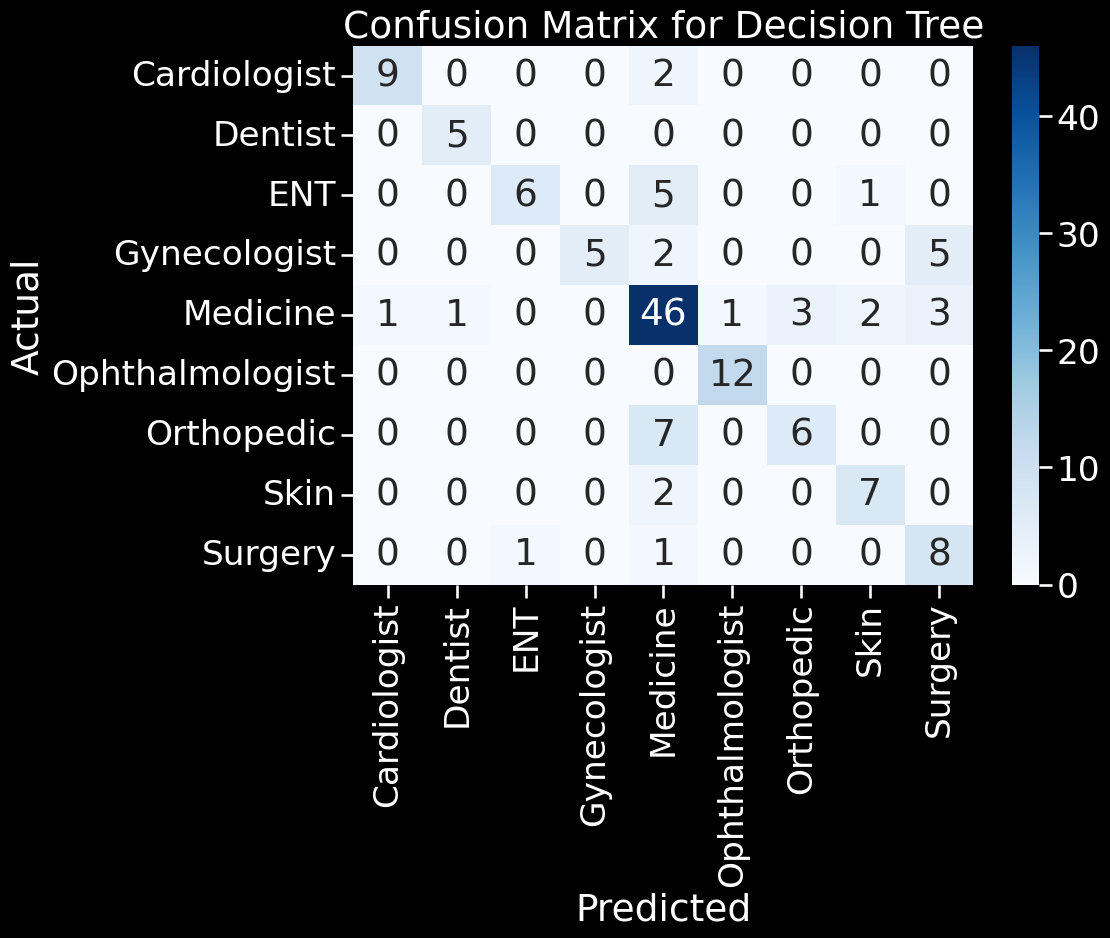

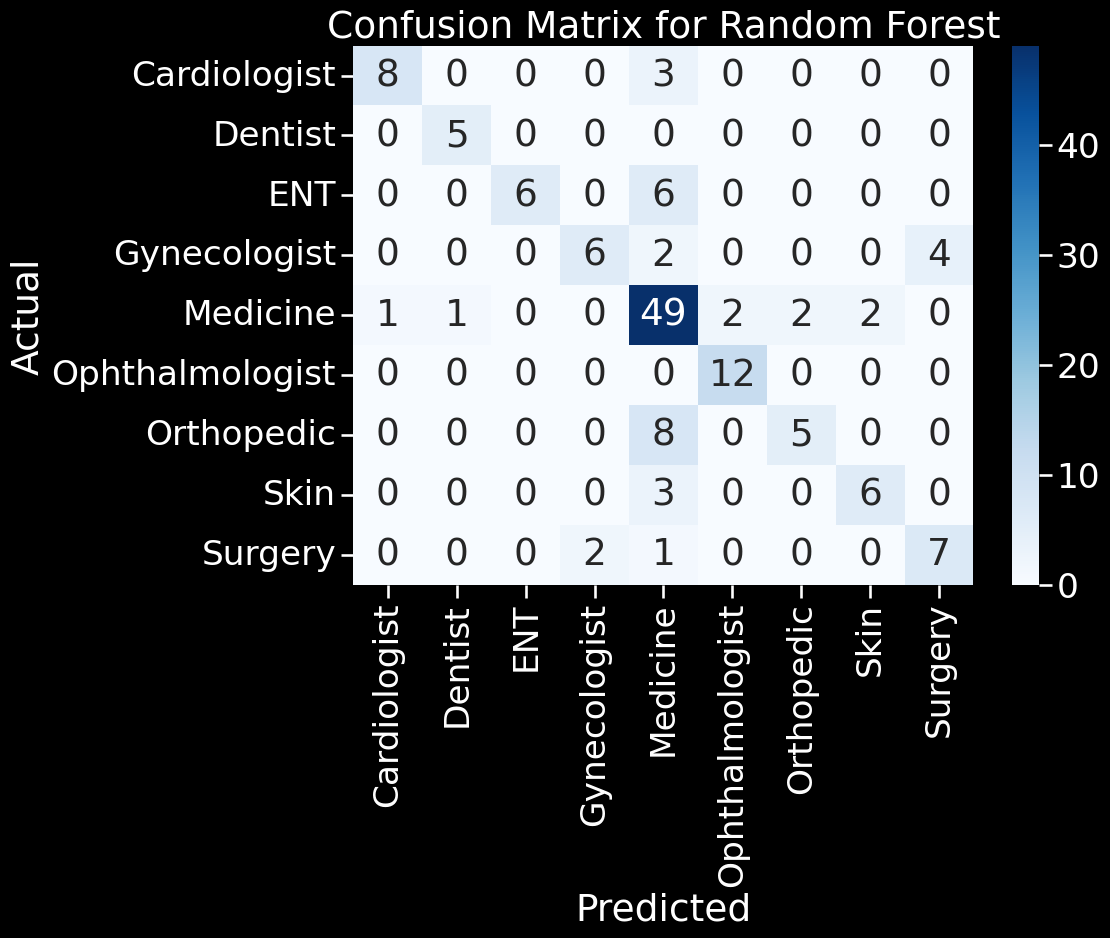

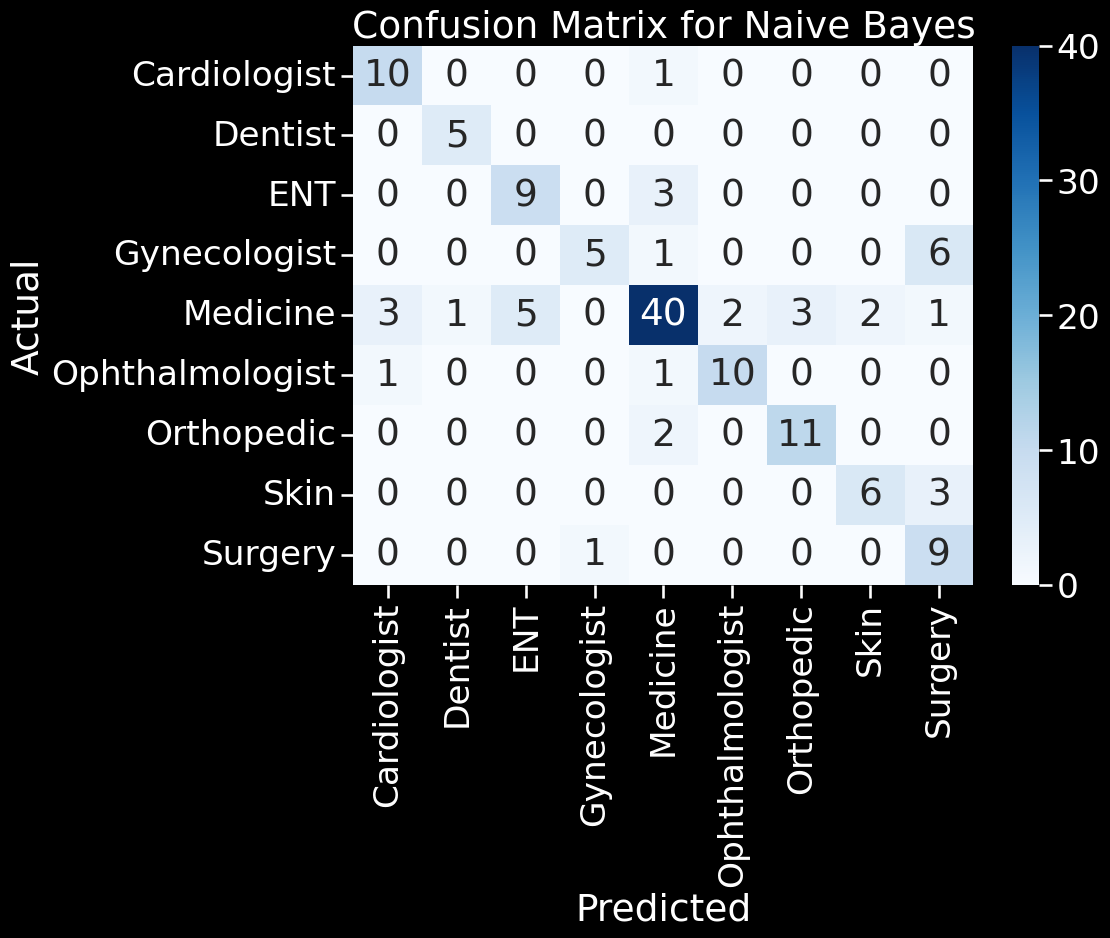

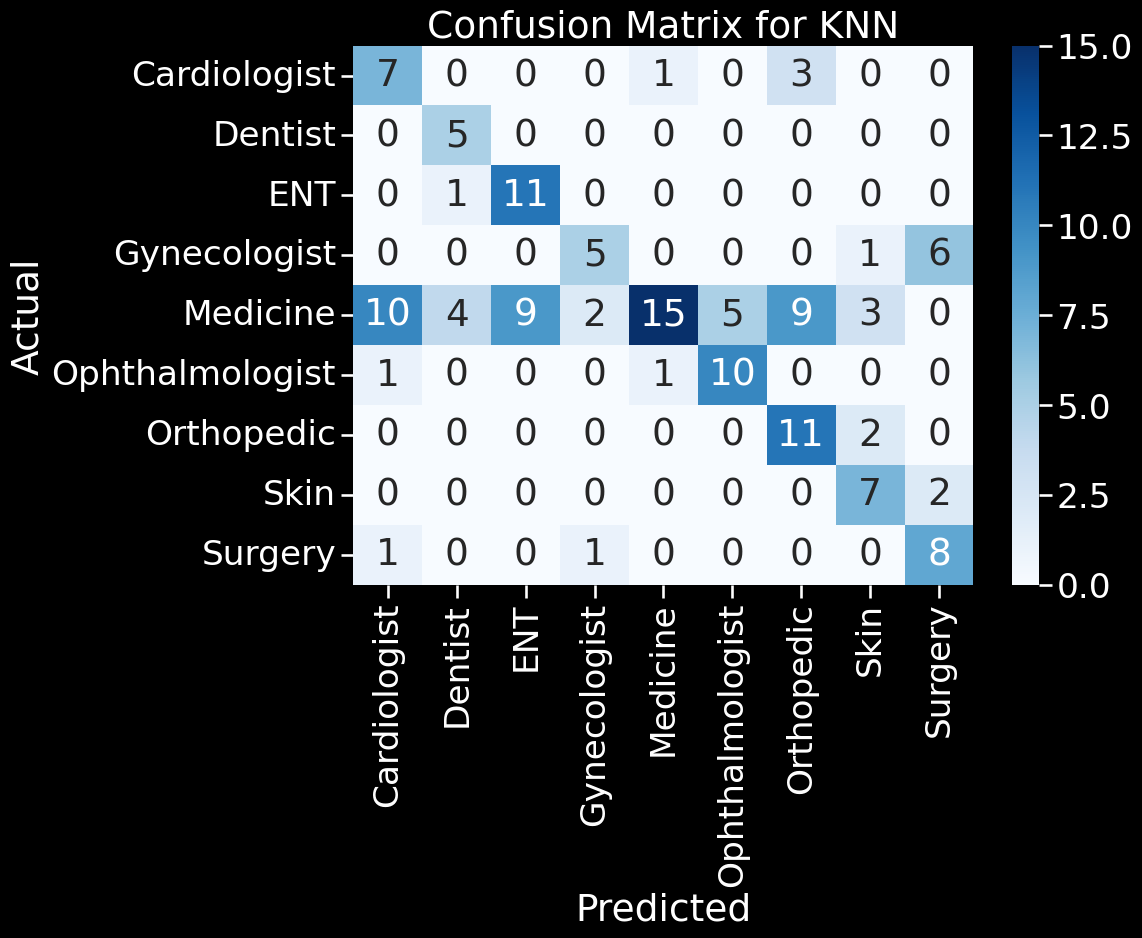

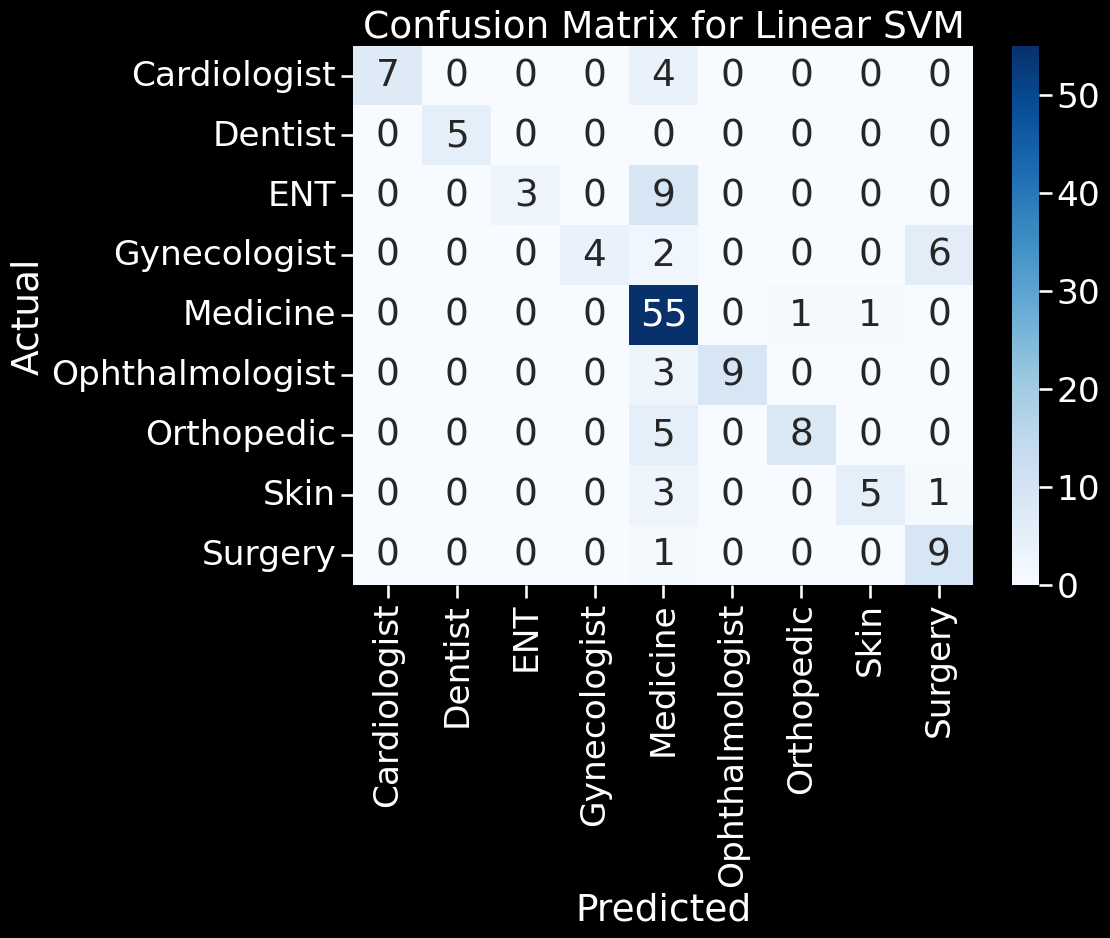

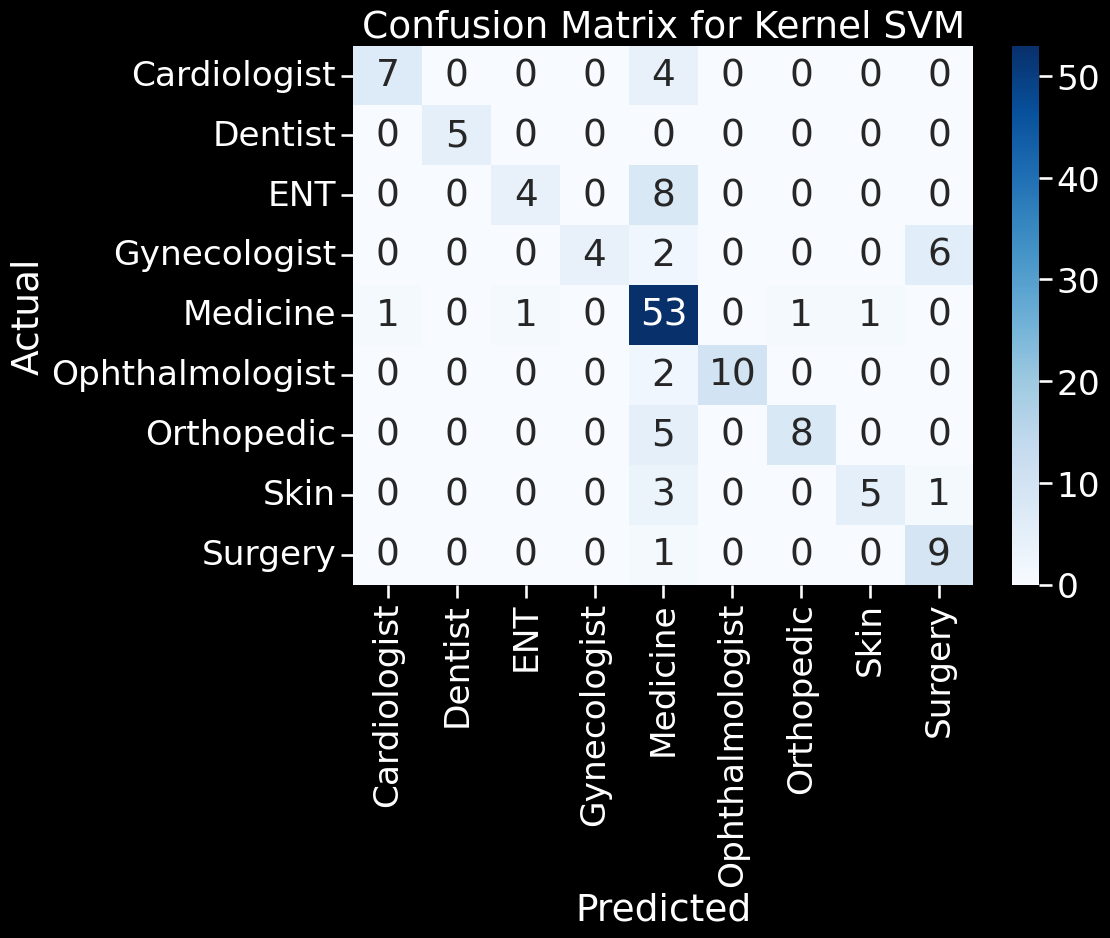

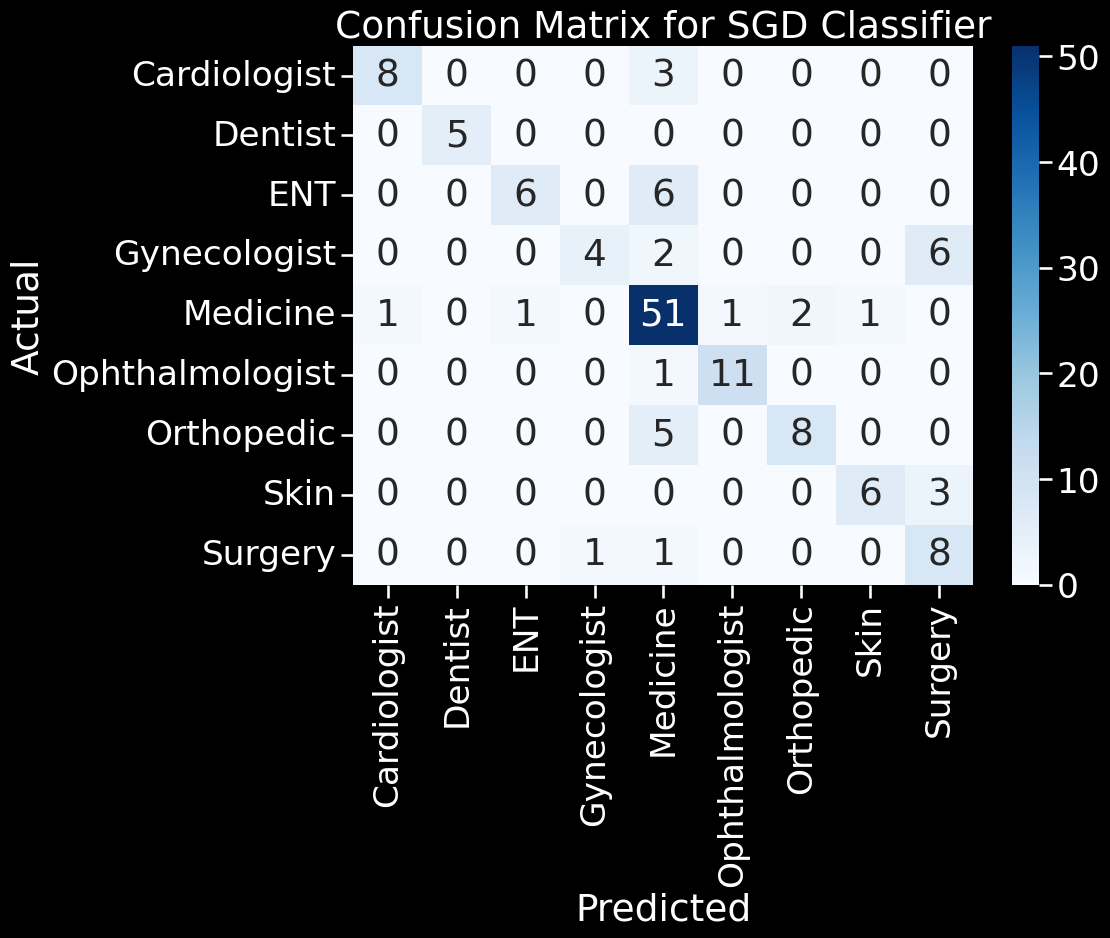

In [ ]:
tfidf,feature = calc_gram_tfidf(new_df.cleaned_problem,(1, 3))
labels, label_encoder = label_encoding(new_df.Specialist, False)
conf_table = show_confusion_matrix(acc, label_encoder)
# Plotting the confusion matrix

In [ ]:
# Function to manually predict with sample text
def predict_sample_text(model, sample_text, vectorizer, label_encoder):
    sample_vector = vectorizer.transform([sample_text])
    predicted_label = model.predict(sample_vector)
    predicted_class = label_encoder.inverse_transform(predicted_label)[0]
    return predicted_class

In [ ]:
# manual prediction
sample_text = ["আমার দাঁত শিরশির করে। ঠান্ডা বা গরম কিছু খেতে পারি না। অনেক অস্বস্তি লাগে।", "আমার নাতনির ঠিকমত পিরিয়ড হচ্ছে না। আর অনেক সাদা স্রাব বের হয়", "আমার দূরের জিনিস দেখতে অনেক কষ্ট হয় আর তখন মাথা ব্যথা করে", "আমার পায়ে পানি আসছে। ঠিকমত হাঁটতে পারছি না", "আমার স্তনের নিপল দিয়ে দুধের মত সাদা রস বের হতে থাকে কিন্তু আমি প্রেগন্যান্ট না।", "আমি কাছ থেকে কিছু দেখতে গেলে অনেক মাথা ব্যথা করে মনে হয় চোখে অনেক প্রেসার পরছে।"]
sample_output = ['Dentist', 'Gynecologist', 'Ophthalmologist', 'Medicine', 'Surgery', 'Ophthalmologist' ]
dt_model = ml_models[0]

for i, text in enumerate(sample_text) :
  cleaned_sample_txt = preprocessing(text)
  predicted_class = predict_sample_text(dt_model, cleaned_sample_txt, tfidf, label_encoder)
  print(f"Problem :  '{text}' \nPredicted Class : '{predicted_class}'\nActual Class : '{sample_output[i]}'\n")

Problem :  'আমার দাঁত শিরশির করে। ঠান্ডা বা গরম কিছু খেতে পারি না। অনেক অস্বস্তি লাগে।' 
Predicted Class : 'Dentist'
Actual Class : 'Dentist'

Problem :  'আমার নাতনির ঠিকমত পিরিয়ড হচ্ছে না। আর অনেক সাদা স্রাব বের হয়' 
Predicted Class : 'Gynecologist'
Actual Class : 'Gynecologist'

Problem :  'আমার দূরের জিনিস দেখতে অনেক কষ্ট হয় আর তখন মাথা ব্যথা করে' 
Predicted Class : 'Ophthalmologist'
Actual Class : 'Ophthalmologist'

Problem :  'আমার পায়ে পানি আসছে। ঠিকমত হাঁটতে পারছি না' 
Predicted Class : 'Medicine'
Actual Class : 'Medicine'

Problem :  'আমার স্তনের নিপল দিয়ে দুধের মত সাদা রস বের হতে থাকে কিন্তু আমি প্রেগন্যান্ট না।' 
Predicted Class : 'Surgery'
Actual Class : 'Surgery'

Problem :  'আমি কাছ থেকে কিছু দেখতে গেলে অনেক মাথা ব্যথা করে মনে হয় চোখে অনেক প্রেসার পরছে।' 
Predicted Class : 'Ophthalmologist'
Actual Class : 'Ophthalmologist'

